## Description

## Libraries

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.decomposition import IncrementalPCA
from sklearn.metrics import log_loss
import dask.dataframe as dd
import matplotlib.pyplot as plt

## Versions

## Get Data

In [2]:
path = '/Users/davidziganto/data/'

#X_train = pd.read_hdf(path + 'raw_HIGGS_training_data.h5', 'table')
#y_train = X_train.pop('label')

X_test = pd.read_hdf(path + 'raw_HIGGS_test_data.h5', key='/a')
y_test = X_test.pop('label')

#### Dask

In [3]:
# Multiple files
#df = dd.read_hdf(path + 'for_iterating/*.h5', key='/*')

# Single large file
df = dd.read_hdf(path + 'raw_HIGGS_training_data.h5', key='/a')

In [4]:
# create dictionary for online_learning function
dask_dict = {i: df.get_partition(i) for i in range(df.npartitions)}

## Online Learning

#### Instantiate Models

#### Mini-Batch (by partition)

In [5]:
def online_learning(dask_dict, num_classes, model='lr', std_scale=0, pca=0):
    '''
    Inputs:
        dask_dict: dictionary of index as key and dask partition data as value
        num_classes: int denoting total number of classes present in target variable
        model: string denoting which model to use, 'lr' for logistic regression or 'nb' for naive bayes
        std_scale: flag variable (0,1) allowing user to turn on/off StandardScaler
        pca: flag variable (0,1) allowing user to turn on/off Incremental PCA
    Output:
        logloss: list of logloss values achieved during each iteration
    '''
    # Instantiate Models
    if model == 'nb':
        model = BernoulliNB(alpha=1.0, binarize=0.0, fit_prior=True, class_prior=None)
    elif model == 'lr':
        model = SGDClassifier(loss='log', 
                              penalty='elasticnet', 
                              alpha=0.01, 
                              l1_ratio=0.5,
                              fit_intercept=True, 
                              n_iter=1, 
                              shuffle=False, 
                              verbose=1, 
                              epsilon=None,
                              n_jobs=-1, 
                              random_state=123,
                              learning_rate='optimal',
                              eta0=0.0, 
                              power_t=0.5,
                              class_weight=None,
                              warm_start=False, 
                              average=True)
    else:
        raise Exception('Choose either "lr" or "nb" for model')
        
    # Setup
    logloss = []
    ss = StandardScaler()
    ipca = IncrementalPCA(n_components=10, whiten=True, copy=True, batch_size=None)
    counter, max_k = 0, max(dask_dict.keys())  ## for progress updates (partition numbers)
    for k,v in dask_dict.items():
        X_train = df.loc[:, v.columns != 'label']
        y_train = df.loc[:, 'label']
        if std_scale==0 and pca==0:
            model.partial_fit(X_train, y_train, classes=range(num_classes))
            proba = model.predict_proba(X_test)
            logloss.append(log_loss(y_test, proba))
            print('Test log loss: %.4f' % log_loss(y_test, proba))
            print('Partition {0}/{1}\n'.format(counter, max_k))
        elif std_scale and pca==0:
            ss.partial_fit(X_train)
            model.partial_fit(ss.transform(X_train), y_train, classes=range(num_classes))
            proba = model.predict_proba(ss.transform(X_test))
            logloss.append(log_loss(y_test, proba))
            print('Test log loss: %.4f' % log_loss(y_test, proba))
            print('Partition {0}/{1}\n'.format(counter, max_k))
        elif std_scale==0 and pca:
            raise Exception('You have to set std_scale=1 for PCA to work')
        else: 
            ss.partial_fit(X_train)
            ipca.partial_fit(ss.transform(X_train))
            model.partial_fit(ipca.transform(X_train), y_train, classes=range(num_classes))
            proba = model.predict_proba(ipca.transform(ss.transform(X_test)))
            logloss.append(log_loss(y_test, proba))
            print('Test log loss: %.4f' % log_loss(y_test, proba))
            print('Partition {0}/{1}\n'.format(counter, max_k))
        counter += 1
    return logloss

#### Logistic Regression

In [6]:
baseline = online_learning(dask_dict, num_classes=2, model='lr', std_scale=0, pca=0)

-- Epoch 1
Norm: 1.88, NNZs: 14, Bias: 0.858057, T: 8800000, Avg. loss: 0.656561
Total training time: 2.64 seconds.
Test log loss: 1.5248
Partition 0/8

-- Epoch 1
Norm: 1.52, NNZs: 13, Bias: 0.335998, T: 8800000, Avg. loss: 0.656892
Total training time: 2.71 seconds.
Test log loss: 1.0378
Partition 1/8

-- Epoch 1
Norm: 1.39, NNZs: 13, Bias: 0.205140, T: 8800000, Avg. loss: 0.656677
Total training time: 2.73 seconds.
Test log loss: 0.8802
Partition 2/8

-- Epoch 1
Norm: 1.31, NNZs: 13, Bias: 0.146430, T: 8800000, Avg. loss: 0.656572
Total training time: 3.04 seconds.
Test log loss: 0.8071
Partition 3/8

-- Epoch 1
Norm: 1.26, NNZs: 13, Bias: 0.113689, T: 8800000, Avg. loss: 0.656507
Total training time: 5.03 seconds.
Test log loss: 0.7666
Partition 4/8

-- Epoch 1
Norm: 1.22, NNZs: 13, Bias: 0.092890, T: 8800000, Avg. loss: 0.656465
Total training time: 3.89 seconds.
Test log loss: 0.7415
Partition 5/8

-- Epoch 1
Norm: 1.20, NNZs: 13, Bias: 0.078519, T: 8800000, Avg. loss: 0.656435
T

In [7]:
std = online_learning(dask_dict, num_classes=2, std_scale=1, pca=0)

-- Epoch 1
Norm: 1.83, NNZs: 16, Bias: 0.117786, T: 8800000, Avg. loss: 0.642882
Total training time: 2.57 seconds.
Test log loss: 1.6782
Partition 0/8

-- Epoch 1
Norm: 1.42, NNZs: 16, Bias: 0.119119, T: 8800000, Avg. loss: 0.642745
Total training time: 4.15 seconds.
Test log loss: 1.1093
Partition 1/8

-- Epoch 1
Norm: 1.27, NNZs: 16, Bias: 0.119668, T: 8800000, Avg. loss: 0.642781
Total training time: 3.59 seconds.
Test log loss: 0.9194
Partition 2/8

-- Epoch 1
Norm: 1.18, NNZs: 16, Bias: 0.119823, T: 8800000, Avg. loss: 0.642817
Total training time: 3.93 seconds.
Test log loss: 0.8297
Partition 3/8

-- Epoch 1
Norm: 1.13, NNZs: 16, Bias: 0.119487, T: 8800000, Avg. loss: 0.642853
Total training time: 3.71 seconds.
Test log loss: 0.7795
Partition 4/8

-- Epoch 1
Norm: 1.09, NNZs: 16, Bias: 0.118557, T: 8800000, Avg. loss: 0.642889
Total training time: 2.39 seconds.
Test log loss: 0.7483
Partition 5/8

-- Epoch 1
Norm: 1.06, NNZs: 16, Bias: 0.117056, T: 8800000, Avg. loss: 0.642925
T

In [8]:
pca = online_learning(dask_dict, num_classes=2, model='lr', std_scale=1, pca=1)

-- Epoch 1
Norm: 0.75, NNZs: 6, Bias: 0.320957, T: 8800000, Avg. loss: 0.686357
Total training time: 1.23 seconds.
Test log loss: 1.2751
Partition 0/8

-- Epoch 1
Norm: 0.47, NNZs: 6, Bias: 0.213794, T: 8800000, Avg. loss: 0.687197
Total training time: 1.21 seconds.
Test log loss: 0.9373
Partition 1/8

-- Epoch 1
Norm: 0.38, NNZs: 6, Bias: 0.152918, T: 8800000, Avg. loss: 0.687533
Total training time: 1.23 seconds.
Test log loss: 0.8325
Partition 2/8

-- Epoch 1
Norm: 0.34, NNZs: 6, Bias: 0.115566, T: 8800000, Avg. loss: 0.687696
Total training time: 1.27 seconds.
Test log loss: 0.7852
Partition 3/8

-- Epoch 1
Norm: 0.31, NNZs: 5, Bias: 0.103842, T: 8800000, Avg. loss: 0.687761
Total training time: 1.26 seconds.
Test log loss: 0.7590
Partition 4/8

-- Epoch 1
Norm: 0.29, NNZs: 4, Bias: 0.099056, T: 8800000, Avg. loss: 0.687802
Total training time: 1.26 seconds.
Test log loss: 0.7425
Partition 5/8

-- Epoch 1
Norm: 0.28, NNZs: 4, Bias: 0.095422, T: 8800000, Avg. loss: 0.687829
Total tr

#### Naive Bayes

In [9]:
nb_std = online_learning(dask_dict, num_classes=2, model='nb', std_scale=1, pca=0)

Test log loss: 0.6502
Partition 0/8

Test log loss: 0.6502
Partition 1/8

Test log loss: 0.6502
Partition 2/8

Test log loss: 0.6502
Partition 3/8

Test log loss: 0.6502
Partition 4/8

Test log loss: 0.6502
Partition 5/8

Test log loss: 0.6502
Partition 6/8

Test log loss: 0.6502
Partition 7/8

Test log loss: 0.6502
Partition 8/8



## Plot Log Loss on Test Set

In [10]:
def plot_function(log_loss_dict):
    '''
    Input:
        log_loss_dict: a dictionary where the key is a name and the values are log loss values by iteration
    Output:
        plot with labeled axes and title showing difference between baseline, StandardScaler, and PCA approaches
    '''
    colors = ('darkred', 'darkblue', 'darkgreen')
    num_keys = len(log_loss_dict.keys())
    counter, legend = 0, []
    for k,v in log_loss_dict.items():
        plt.plot(range(len(v)), v, '.-', color=colors[counter])
        counter +=1
        legend.append(k)
    plt.xlabel('iteration #')
    plt.ylabel('log loss value (test set)')
    plt.title('log loss vs iteration #')
    plt.legend(legend)

In [11]:
log_loss_dict = {'baseline':baseline, 'standardized':std, 'pca':pca}

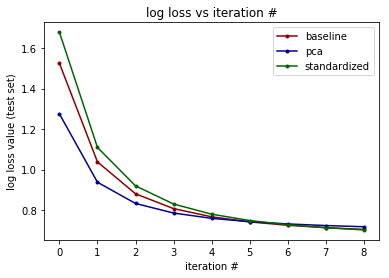

In [12]:
plot_function(log_loss_dict)

# To do

* multiple passes over shuffled datasets
* cleanup code
* optimize for performance
* source > 16GB dataset
* scale on AWS